In [ ]:

!unzip -q "/content/mnist_c.zip" -d "/content/mnist_c"


In [ ]:
!ls /content/mnist_c/mnist_c


brightness


In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

 
base = "/content/mnist_c/mnist_c/brightness"

#loading the arrays
X_train = np.load(f"{base}/train_images.npy") / 255.0
y_train = np.load(f"{base}/train_labels.npy")
X_test  = np.load(f"{base}/test_images.npy")  / 255.0
y_test  = np.load(f"{base}/test_labels.npy")
y_train = to_categorical(y_train, num_classes=10)
y_test  = to_categorical(y_test,  num_classes=10)
if X_train.ndim == 3:
    X_train = X_train[..., np.newaxis]
    X_test  = X_test[...,  np.newaxis]

print("Shapes:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)


Shapes: (60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


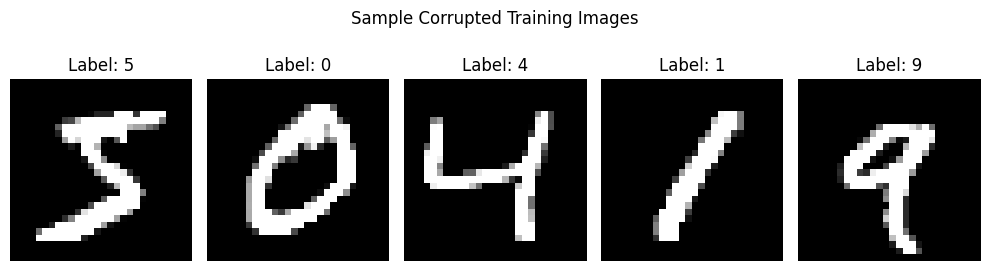


=== MC Dropout ===
Epoch 1/10
 34/750 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.1347 - loss: 2.2889

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
)
from tensorflow.keras.models import Model
import tensorflow_probability as tfp

# reproducibility
np.random.seed(42)
tf.random.set_seed(42)

tfpl = tfp.layers
tfd  = tfp.distributions


def load_corrupted_data():
    """
    Load pre-saved NumPy arrays from the local Colab filesystem.
    Expects:
      /content/mnist_c/brightness/
        ├── train_images.npy
        ├── train_labels.npy
        ├── test_images.npy
        └── test_labels.npy
    """
    base = Path("/content/mnist_c/mnist_c/brightness")
    x_train = np.load(base / "train_images.npy")
    y_train = np.load(base / "train_labels.npy")
    x_test  = np.load(base / "test_images.npy")
    y_test  = np.load(base / "test_labels.npy")

    # Normalize & add channel dim
    x_train = x_train[..., None] / 255.0
    x_test  = x_test[..., None]  / 255.0

    return x_train, y_train, x_test, y_test


def visualize_corruptions(images, labels, n_samples=5, title=""):
    """Show a few corrupted examples."""
    plt.figure(figsize=(10, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# --- MC Dropout CNN ---
def create_mc_dropout_model():
    inp = Input(shape=(28, 28, 1))
    x = Conv2D(32, 3, activation='relu')(inp)
    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(10, activation='softmax')(x)

    return Model(inp, out)


def train_model(model, x_train, y_train):
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model.fit(
        x_train, y_train,
        batch_size=64,
        epochs=10,
        validation_split=0.2
    )


def mc_predict(model, x, n_samples=50):
    """T stochastic forward passes with dropout on."""
    return np.stack([model(x, training=True) for _ in range(n_samples)])


def analyze_results(preds, true_labels):
    """
    Compute accuracy, entropy, std, error rate,
    plot confidence histograms and entropy plots.
    """
    # mean predictive distribution
    mean_p = preds.mean(axis=0)
    pred_labels = mean_p.argmax(axis=1)

    # metrics
    accuracy = np.mean(pred_labels == true_labels)
    entropies = -np.sum(mean_p * np.log(mean_p + 1e-8), axis=1)
    stds = preds.std(axis=0).mean(axis=1)
    error_rate = 1 - accuracy

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Avg. Entropy: {entropies.mean():.4f}")
    print(f"Avg. Std-dev: {stds.mean():.4f}")
    print(f"Error rate: {error_rate:.4f}")

    # plots
    confidences = mean_p.max(axis=1)
    correct = pred_labels == true_labels

    plt.figure(figsize=(15, 4))

    # confidence histogram
    plt.subplot(1, 3, 1)
    plt.hist(confidences[correct], bins=20, alpha=0.5, label='Correct')
    plt.hist(confidences[~correct], bins=20, alpha=0.5, label='Incorrect')
    plt.title("Confidence Distribution")
    plt.legend()

    # confidence vs entropy
    plt.subplot(1, 3, 2)
    plt.scatter(confidences, entropies, c=correct, alpha=0.6)
    plt.title("Confidence vs Entropy")

    # entropy histogram
    plt.subplot(1, 3, 3)
    plt.hist(entropies[correct], bins=20, alpha=0.5, label='Correct')
    plt.hist(entropies[~correct], bins=20, alpha=0.5, label='Incorrect')
    plt.title("Entropy Distribution")
    plt.legend()

    plt.tight_layout()
    plt.show()


# --- Ensemble Monte Carlo (EMC) Dropout ---
def train_ensemble_mc(M, x_train, y_train):
    models = []
    for i in range(M):
        print(f"\nTraining model {i+1}/{M} of EMC-Dropout")
        m = create_mc_dropout_model()
        m.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        m.fit(x_train, y_train,
              batch_size=64, epochs=10,
              validation_split=0.2, verbose=1)
        models.append(m)
    return models


def emc_predict(models, x, n_samples=50):
    """
    Run T passes on each of M models, then stack:
      output shape = (M*T, N, C)
    """
    all_preds = [mc_predict(m, x, n_samples) for m in models]
    return np.concatenate(all_preds, axis=0)


# --- Ensemble Bayesian Neural Network (EBNN) ---
def create_bayesian_cnn():
    inp = Input(shape=(28, 28, 1))
    x = Conv2D(32, 3, activation='relu')(inp)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = tfpl.DenseFlipout(128, activation='relu')(x)
    x = tfpl.DenseFlipout(10, activation=None)(x)
    out = tfpl.DistributionLambda(
        lambda logits: tfd.Categorical(logits=logits),
        convert_to_tensor_fn=lambda d: d.probs
    )(x)
    return Model(inp, out)


def ebnn_predict_samples(model, x, n_samples=50):
    return np.stack([model(x, training=True).numpy() for _ in range(n_samples)],
                    axis=0)


if __name__ == "__main__":
    # 1) load data
    x_train, y_train, x_test, y_test = load_corrupted_data()

    # 2) visualize some examples
    visualize_corruptions(x_train[:5]*255, y_train[:5],
                          title="Sample Corrupted Training Images")

    # --- MC Dropout ---
    print("\n=== MC Dropout ===")
    mc_model = create_mc_dropout_model()
    train_model(mc_model, x_train, y_train)
    mc_preds = mc_predict(mc_model, x_test, n_samples=50)
    analyze_results(mc_preds, y_test)

    # --- EMC Dropout ---
    print("\n=== EMC Dropout ===")
    ensemble = train_ensemble_mc(M=5, x_train=x_train, y_train=y_train)
    emc_preds = emc_predict(ensemble, x_test, n_samples=50)
    analyze_results(emc_preds, y_test)

    # --- EBNN ---
    print("\n=== Ensemble Bayesian NN ===")
    # one-hot for ELBO loss
    y_train_ohe = tf.keras.utils.to_categorical(y_train, 10)
    y_test_ohe  = tf.keras.utils.to_categorical(y_test,  10)

    bnn = create_bayesian_cnn()
    negloglik = lambda y, rv: -rv.log_prob(tf.argmax(y, axis=1))
    bnn.compile(optimizer='adam', loss=negloglik, metrics=['accuracy'])
    bnn.fit(x_train, y_train_ohe,
            batch_size=64, epochs=10, validation_split=0.2)

    ebnn_preds = ebnn_predict_samples(bnn, x_test, n_samples=50)
    analyze_results(ebnn_preds, y_test)



### EMC-Dropout Plots ###


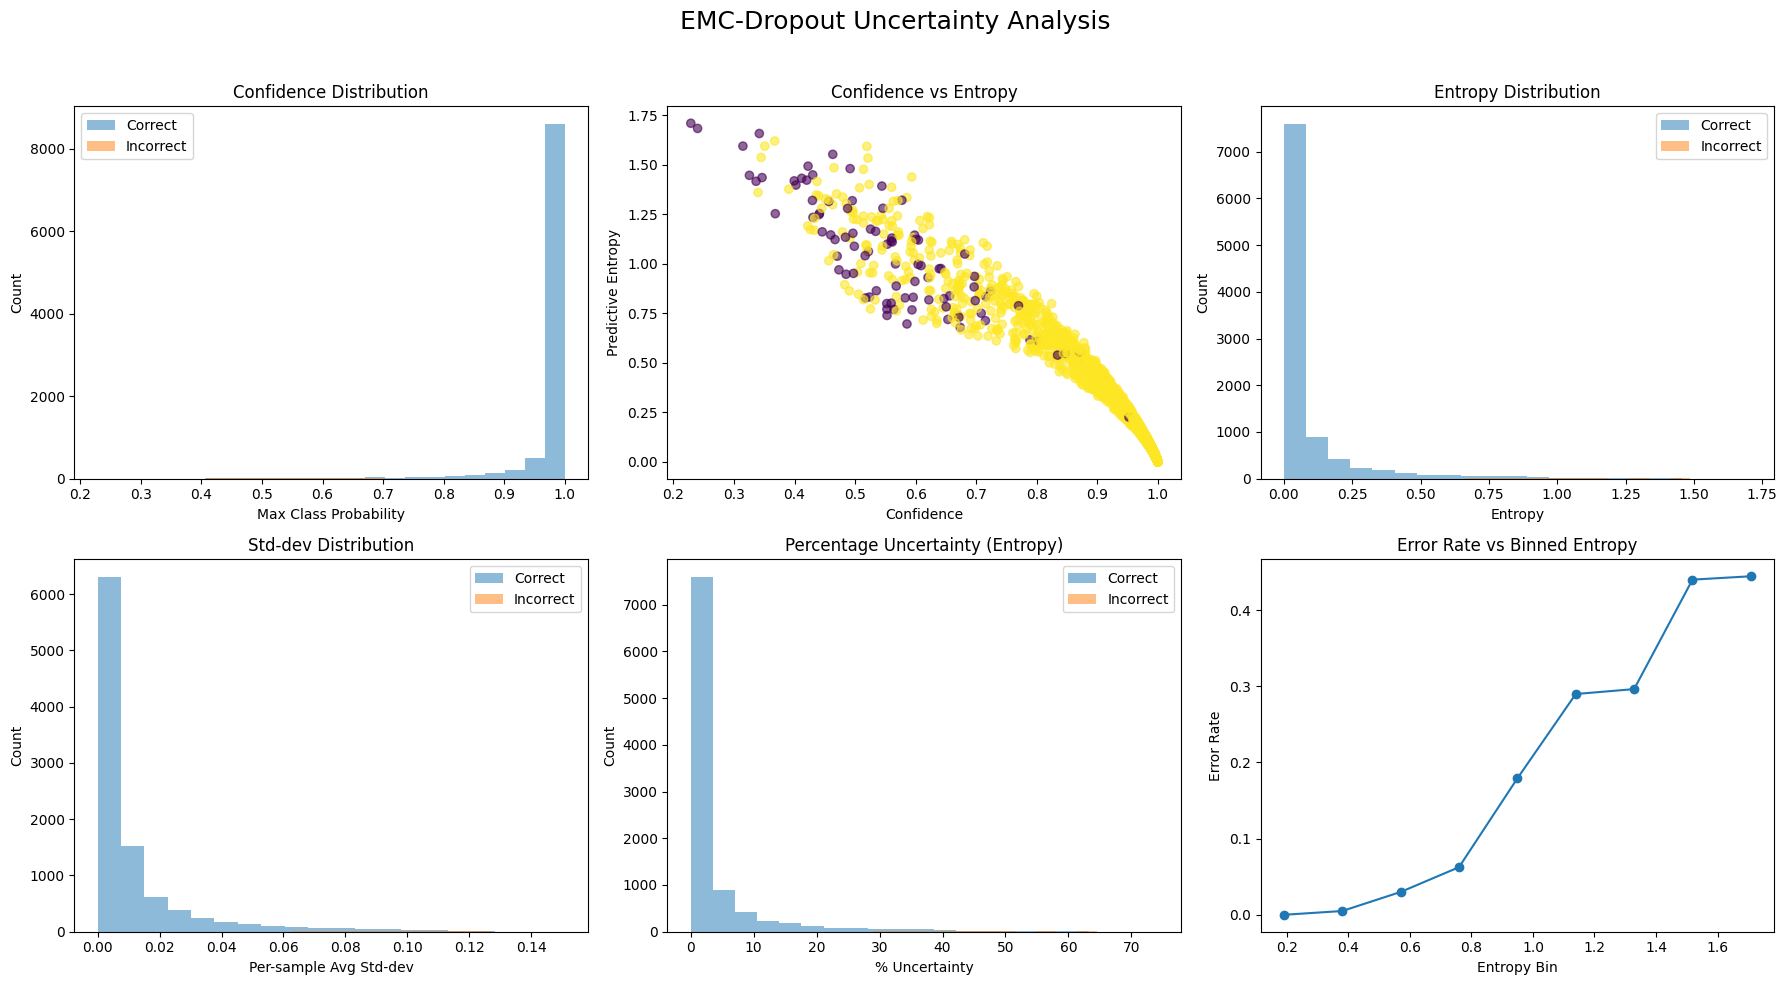


### EBNN Plots ###


NameError: name 'ebnn_preds' is not defined

In [ ]:
import matplotlib.pyplot as plt

def plot_uncertainty(preds, true_labels, title):
    """
    preds: array of shape (T_eff, N, C)
    true_labels: array of shape (N,)
    title:"
    """
    #summary stats
    mean_p      = preds.mean(axis=0)                # (N, C)
    pred_labels = mean_p.argmax(axis=1)             # (N,)
    correct     = (pred_labels == true_labels)      # (N,)
    confidences = mean_p.max(axis=1)                # (N,)
    entropies   = -np.sum(mean_p * np.log(mean_p + 1e-8), axis=1)  # (N,)
    stds        = preds.std(axis=0).mean(axis=1)    

#percentage uncertainty (entropy-based)

    max_ent = -np.log(1/10)  # for 10 classes

    perc_unc_ent = (entropies / max_ent) * 100      # (N,)

#plot everything in a 2×3 grid
    plt.figure(figsize=(18, 10))
    plt.suptitle(f"{title} Uncertainty Analysis", fontsize=18)

#confidence Histogram
    plt.subplot(2, 3, 1)
    plt.hist(confidences[correct],   bins=20, alpha=0.5, label='Correct')
    plt.hist(confidences[~correct],  bins=20, alpha=0.5, label='Incorrect')
    plt.title("Confidence Distribution")
    plt.xlabel("Max Class Probability")
    plt.ylabel("Count")
    plt.legend()

    #confidence vs Entropy
    plt.subplot(2, 3, 2)
    plt.scatter(confidences, entropies, c=correct, alpha=0.6)
    plt.title("Confidence vs Entropy")
    plt.xlabel("Confidence")
    plt.ylabel("Predictive Entropy")

    #entropy Histogram
    plt.subplot(2, 3, 3)
    plt.hist(entropies[correct],   bins=20, alpha=0.5, label='Correct')
    plt.hist(entropies[~correct],  bins=20, alpha=0.5, label='Incorrect')
    plt.title("Entropy Distribution")
    plt.xlabel("Entropy")
    plt.ylabel("Count")
    plt.legend()

    #Std-dev Distribution
    plt.subplot(2, 3, 4)
    plt.hist(stds[correct],   bins=20, alpha=0.5, label='Correct')
    plt.hist(stds[~correct],  bins=20, alpha=0.5, label='Incorrect')
    plt.title("Std-dev Distribution")
    plt.xlabel("Per-sample Avg Std-dev")
    plt.ylabel("Count")
    plt.legend()

    #% Uncertainty (Entropy-based)
    plt.subplot(2, 3, 5)
    plt.hist(perc_unc_ent[correct],   bins=20, alpha=0.5, label='Correct')
    plt.hist(perc_unc_ent[~correct],  bins=20, alpha=0.5, label='Incorrect')
    plt.title("Percentage Uncertainty (Entropy)")
    plt.xlabel("% Uncertainty")
    plt.ylabel("Count")
    plt.legend()

    #Error Rate vs. Binned Entropy
    plt.subplot(2, 3, 6)
    bins = np.linspace(entropies.min(), entropies.max(), 10)
    bin_ids = np.digitize(entropies, bins)
    err_rate_per_bin = [
        1 - np.mean(pred_labels[bin_ids==i] == true_labels[bin_ids==i])
        for i in range(1, len(bins))
    ]
    plt.plot(bins[1:], err_rate_per_bin, marker='o')
    plt.title("Error Rate vs Binned Entropy")
    plt.xlabel("Entropy Bin")
    plt.ylabel("Error Rate")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# — after EMC predictions —
print("\n### EMC-Dropout Plots ###")
plot_uncertainty(emc_preds, y_test, title="EMC-Dropout")

# — after EBNN predictions —
print("\n### EBNN Plots ###")
plot_uncertainty(ebnn_preds, y_test, title="EBNN")


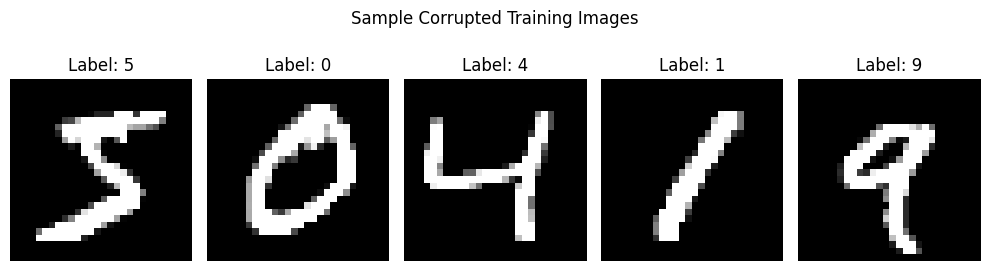


Training model 1/5...
Epoch 1/10
750/750 - 44s - 59ms/step - accuracy: 0.8064 - loss: 0.5980 - val_accuracy: 0.9633 - val_loss: 0.1292
Epoch 2/10
750/750 - 78s - 104ms/step - accuracy: 0.9404 - loss: 0.2019 - val_accuracy: 0.9747 - val_loss: 0.0838
Epoch 3/10
750/750 - 41s - 55ms/step - accuracy: 0.9570 - loss: 0.1443 - val_accuracy: 0.9822 - val_loss: 0.0631
Epoch 4/10
750/750 - 40s - 54ms/step - accuracy: 0.9651 - loss: 0.1177 - val_accuracy: 0.9857 - val_loss: 0.0516
Epoch 5/10
750/750 - 40s - 54ms/step - accuracy: 0.9706 - loss: 0.0970 - val_accuracy: 0.9870 - val_loss: 0.0440
Epoch 6/10
750/750 - 41s - 55ms/step - accuracy: 0.9740 - loss: 0.0882 - val_accuracy: 0.9865 - val_loss: 0.0463
Epoch 7/10
750/750 - 41s - 55ms/step - accuracy: 0.9758 - loss: 0.0785 - val_accuracy: 0.9888 - val_loss: 0.0405
Epoch 8/10
750/750 - 40s - 54ms/step - accuracy: 0.9783 - loss: 0.0734 - val_accuracy: 0.9883 - val_loss: 0.0399
Epoch 9/10
750/750 - 43s - 58ms/step - accuracy: 0.9790 - loss: 0.0697 -

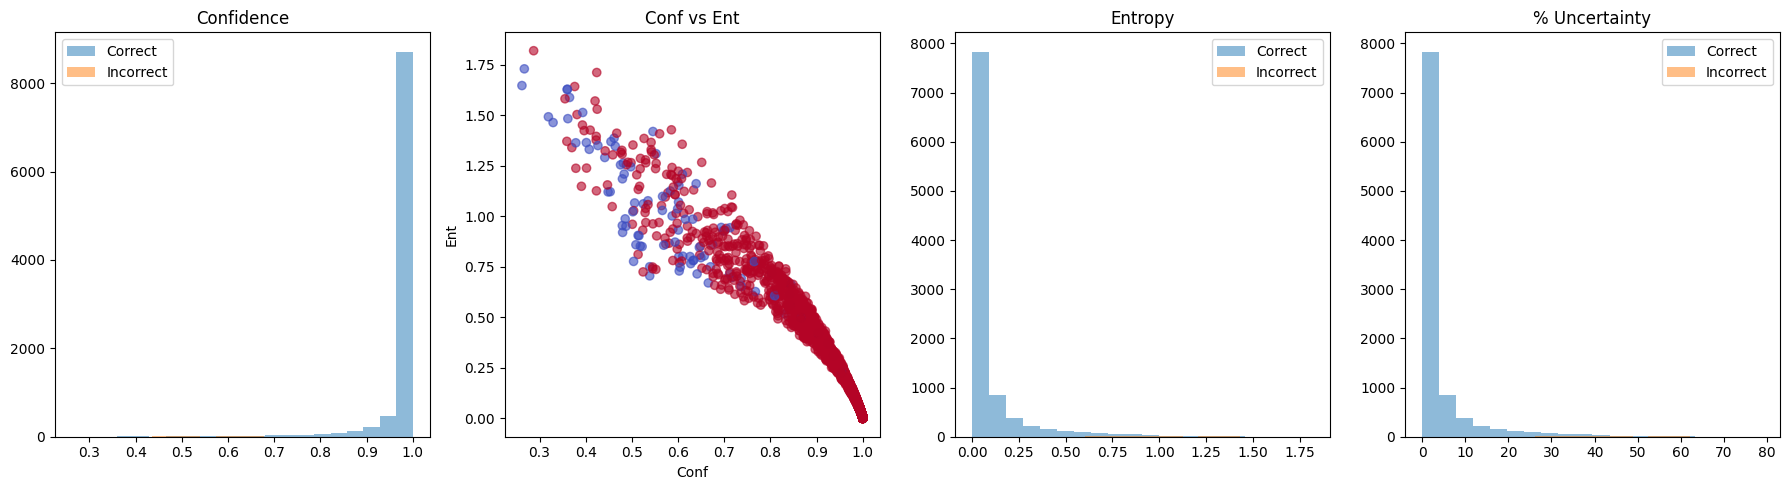

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
)
from tensorflow.keras.models import Model

# reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#load corrupted MNIST-C data
def load_corrupted_data():
    base_path = Path("/content/mnist_c/mnist_c/brightness")
    x_train = np.load(base_path / "train_images.npy")
    y_train = np.load(base_path / "train_labels.npy")
    x_test  = np.load(base_path / "test_images.npy")
    y_test  = np.load(base_path / "test_labels.npy")

    # Ensure shape = (N, 28, 28, 1)
    if x_train.ndim == 3:
        x_train = x_train[..., None]
        x_test  = x_test[...,  None]
    while x_train.ndim > 4:
        x_train = np.squeeze(x_train, axis=-1)
        x_test  = np.squeeze(x_test,  axis=-1)

    #noramlization
    x_train = x_train.astype("float32") / 255.0
    x_test  = x_test.astype("float32") / 255.0

    return x_train, y_train, x_test, y_test


#visualize few examples
def visualize_corruptions(images, labels, n_samples=5, title=""):
    plt.figure(figsize=(10,3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


#build one CNN model with dropout (MC-Dropout & EBNN style)
def build_bayesian_model():
    inp = Input(shape=(28,28,1))
    x = Conv2D(32, 3, activation='relu')(inp)
    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x, training=True)

    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x, training=True)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x, training=True)

    out = Dense(10, activation='softmax')(x)
    return Model(inp, out)


#Train a single model
def train_model(model, x_train, y_train):
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model.fit(x_train, y_train,
                     batch_size=64,
                     epochs=10,
                     validation_split=0.2,
                     verbose=2)


#EBNN‐style ensemble predictions: M models × T=50 passes
def ebnn_predict(ensemble, x, T=50):
    all_preds = []
    for m in ensemble:
        preds_T = [m(x, training=True).numpy() for _ in range(T)]
        all_preds.append(np.stack(preds_T, axis=0))  # (T, N, 10)
    return np.stack(all_preds, axis=0)  # (M, T, N, 10)


#analyze & plot uncertainties
def analyze_results(predictions, true_labels):
    M, T, N, C = predictions.shape
    mean_probs  = predictions.mean(axis=(0,1))  # (N,10)
    pred_labels = mean_probs.argmax(axis=1)
    std_dev     = predictions.std(axis=(0,1))   # (N,10)

    accuracy    = np.mean(pred_labels == true_labels)
    entropies   = -np.sum(mean_probs * np.log(mean_probs + 1e-10), axis=1)
    max_entropy = -np.log(1/C)
    pct_unc_ent = (entropies / max_entropy) * 100
    pct_unc_std = np.mean(std_dev.mean(axis=1)) * 100

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Avg. Entropy: {entropies.mean():.4f}")
    print(f"Avg. % Unc (entropy): {pct_unc_ent.mean():.2f}%")
    print(f"Avg. % Unc (std-dev): {pct_unc_std:.2f}%")
    print(f"Error rate: {1-accuracy:.4f}")

    confidences = mean_probs.max(axis=1)
    correct     = pred_labels == true_labels

    plt.figure(figsize=(18,5))
    #confidence histogram
    plt.subplot(1,4,1)
    plt.hist(confidences[correct], bins=20, alpha=0.5, label='Correct')
    plt.hist(confidences[~correct], bins=20, alpha=0.5, label='Incorrect')
    plt.title("Confidence"); plt.legend()

    #confidence vs Entropy
    plt.subplot(1,4,2)
    plt.scatter(confidences, entropies, c=correct, cmap='coolwarm', alpha=0.6)
    plt.title("Conf vs Ent"); plt.xlabel("Conf"); plt.ylabel("Ent")

    #entropy histogram
    plt.subplot(1,4,3)
    plt.hist(entropies[correct], bins=20, alpha=0.5, label='Correct')
    plt.hist(entropies[~correct], bins=20, alpha=0.5, label='Incorrect')
    plt.title("Entropy"); plt.legend()

    #% Uncertainty histogram
    plt.subplot(1,4,4)
    plt.hist(pct_unc_ent[correct], bins=20, alpha=0.5, label='Correct')
    plt.hist(pct_unc_ent[~correct], bins=20, alpha=0.5, label='Incorrect')
    plt.title("% Uncertainty"); plt.legend()

    plt.tight_layout()
    plt.show()


# ==== MAIN EXECUTION ====
x_train, y_train, x_test, y_test = load_corrupted_data()

visualize_corruptions(x_train[:5]*255, y_train[:5],
                      title="Sample Corrupted Training Images")

M = 5
T = 50
ensemble = []
for i in range(M):
    print(f"\nTraining model {i+1}/{M}...")
    m = build_bayesian_model()
    train_model(m, x_train, y_train)
    ensemble.append(m)

print("\n=== Ensemble Bayesian NN Results ===")
preds = ebnn_predict(ensemble, x_test, T=T)
analyze_results(preds, y_test)


In [ ]:
# Debug: check training data shape
x_train, y_train, x_test, y_test = load_corrupted_data()
print("x_train.shape:", x_train.shape, "ndim:", x_train.ndim)


x_train.shape: (60000, 28, 28, 1) ndim: 4
